## Инициализация библиотек

In [28]:
# 1. Основные библиотеки
import warnings
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 3. Модели
from catboost import CatBoostRegressor

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

#### Пути к файлам

In [ ]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
REPORTS_FILE_PATH = './reports/'

## Вспомогательные функции

#### Функция уменьшения потребляемой памяти

In [29]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Функция для оценки качества модели

In [30]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Загрузка данных

#### Тренировочные данные

In [31]:
df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


#### Тестовые данные

In [32]:
X_final = pd.read_csv(TEST_DATASET_PATH)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


## Анализ данных

#### Нулевые значения

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Нулевые значения имеются в столбцах **LifeSquare** и **Healthcare_1**

#### Проанализируем числовые признаки

In [50]:
df_num_features = df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32'])
df_num_features.drop(['Price', 'Id'], axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016DA3AB4A88>,
      dtype=object)

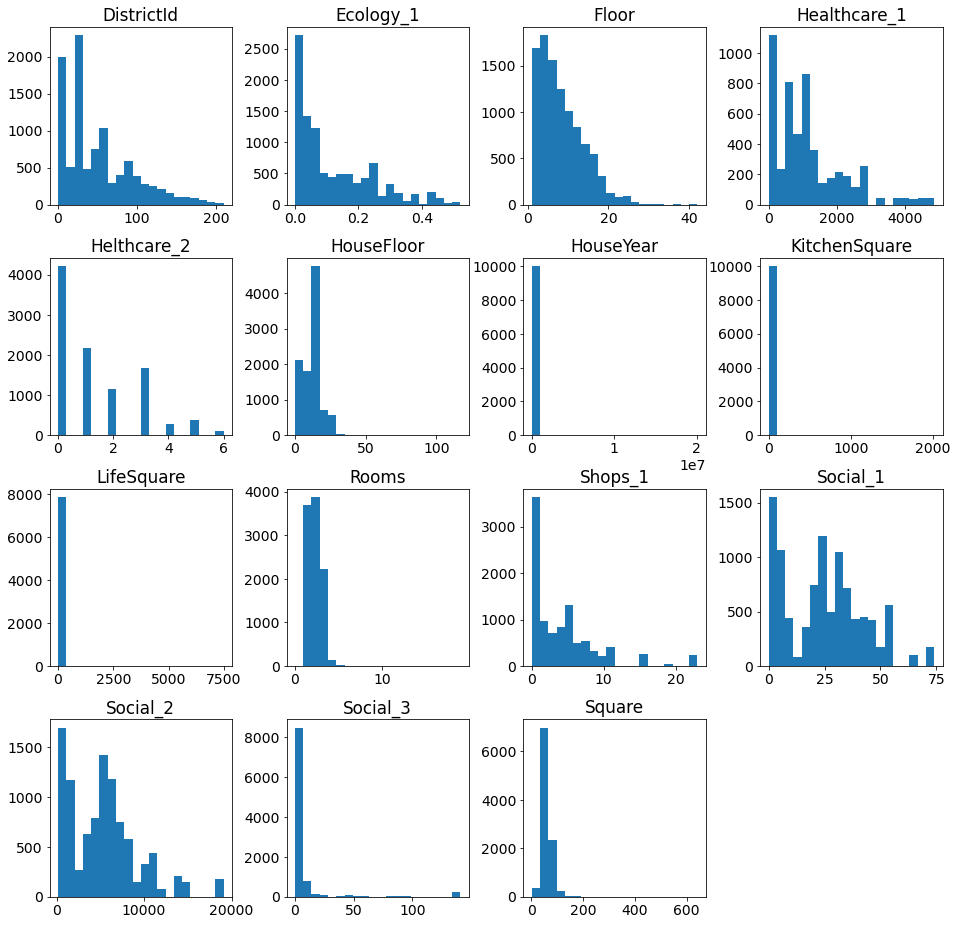

In [51]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

Видно, что по следующим признакам есть выбросы: **HouseYear**, **KitchenSquare**.

Некоторые признаки имеют аномально высокое значение, но вполне вероятное: **HouseFloor**, **LifeSquare**, **Rooms**, **Square**. 
Их необходимо будет ограничить.

#### Рассмотрим статистики датафрейма

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


Дополнительно к предыдущим замечаниям, видно, что признаки **Rooms**, **KitchenSquare**, **HouseFloor** имеют в некоторых наблюдениях нулевые значения

In [69]:
for feat in ['Rooms', 'KitchenSquare', 'HouseFloor']:
    print(f'Количество наблюдений, где {feat}=0: {df.loc[(df[feat] == 0)].shape[0]}')

Количество наблюдений, где Rooms=0: 8
Количество наблюдений, где KitchenSquare=0: 697
Количество наблюдений, где HouseFloor=0: 269


#### Рассмотрим признаки более детально

Rooms

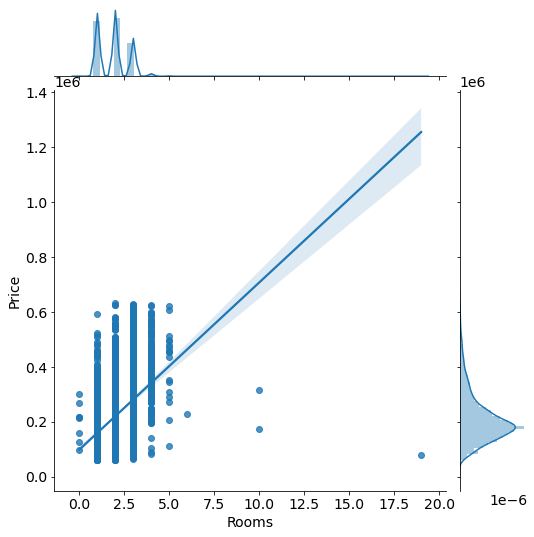

In [72]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Видно, что значения менее 1 и более 5 необходимо обработать

KitchenSquare

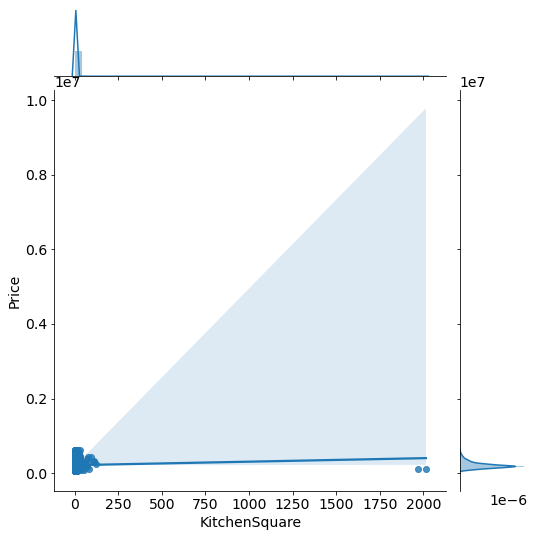

In [77]:
grid = sns.jointplot(df['KitchenSquare'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Отсечем значения меньше 1 и больше 250

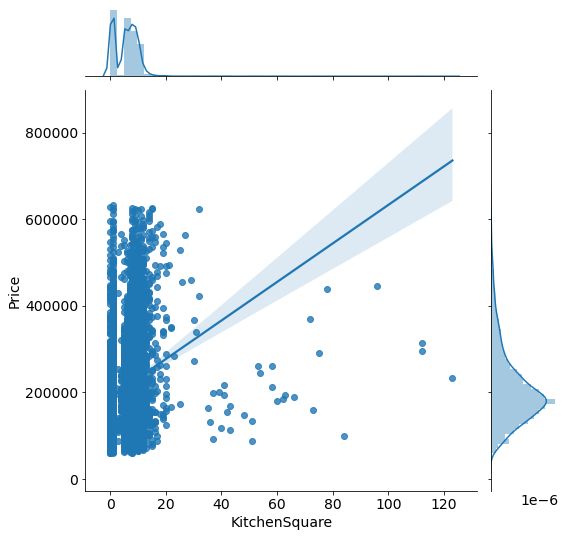

In [81]:
df_temp = df.loc[df['KitchenSquare']<250]
grid = sns.jointplot(df_temp['KitchenSquare'], df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Значения менее 3х м2 и больше 30 будем считать выбросом

Остальные признаки рассматривались по аналогии.

#### График распределения цены

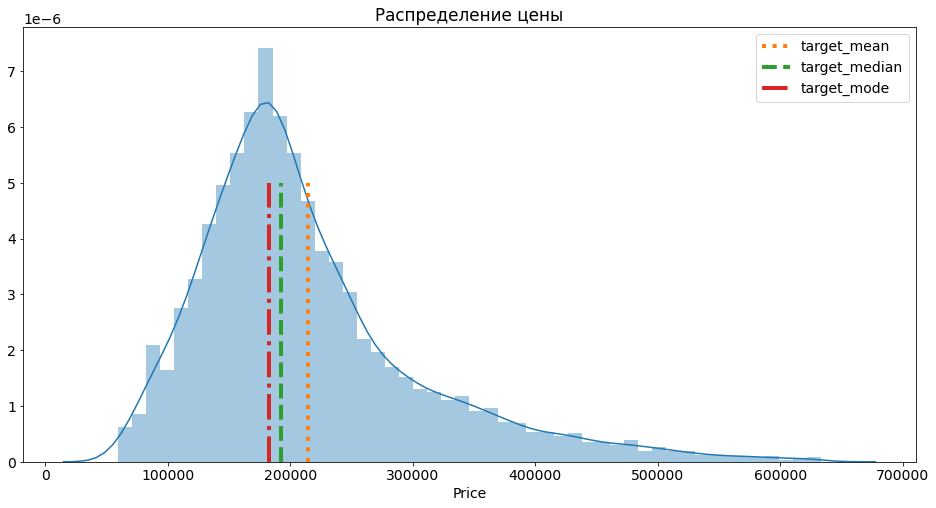

In [34]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='target_mean', linestyle=':',  linewidth=4)
plt.plot([target_median] * 10, y, label='target_median', linestyle='--',  linewidth=4)
plt.plot([target_mode] * 10, y, label='target_mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()

Выглядит неплохо, существенных выбросов нет

## Подготовка данных

In [13]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, df):
        
        # медианные значения
        self.medians = df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_temp
        
    def transform(self, df):
        
        # 1. Пропуски
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # 2. Выбросы
        
        # площадь
        df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        df.loc[(df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def features(self, df):
        
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        df = df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageHealthcare_1'].fillna(df['AverageHealthcare_1'].median(), inplace=True)
        
        return df

In [14]:
data_inst = Data()

data_inst.fit(df)
df = data_inst.transform(df)
df = data_inst.features(df)

X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [15]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [16]:
df = df[feature_names + [target_name]]
X_final = X_final[feature_names + ['Id']]

In [17]:
X = df[feature_names]
y = df[target_name]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

GradientBoostingRegressor

In [19]:
%%time

cbr_model = CatBoostRegressor(
    silent=True,
    eval_metric='R2',
)

params_grid = {
    'depth':[4, 6, 8, 10],
    'learning_rate':[0.02, 0.03, 0.05, 0.1, 0.12],
    'iterations':[1000, 1050, 1100, 1150]
}

gs = cbr_model.randomized_search(
    params_grid,
    X,
    y,
    shuffle=True,
    partition_random_seed=42,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7818971338
bestIteration = 1049

0:	loss: 0.7818971	best: 0.7818971 (0)	total: 2.94s	remaining: 26.5s

bestTest = 0.7814793553
bestIteration = 743

1:	loss: 0.7814794	best: 0.7818971 (0)	total: 5.67s	remaining: 22.7s

bestTest = 0.7814793553
bestIteration = 743

2:	loss: 0.7814794	best: 0.7818971 (0)	total: 8.38s	remaining: 19.5s

bestTest = 0.7826821895
bestIteration = 313

3:	loss: 0.7826822	best: 0.7826822 (3)	total: 12.4s	remaining: 18.6s

bestTest = 0.7901503886
bestIteration = 1115

4:	loss: 0.7901504	best: 0.7901504 (4)	total: 23.4s	remaining: 23.4s

bestTest = 0.790937712
bestIteration = 913

5:	loss: 0.7909377	best: 0.7909377 (5)	total: 33.5s	remaining: 22.3s

bestTest = 0.7838770259
bestIteration = 294

6:	loss: 0.7838770	best: 0.7909377 (5)	total: 44.7s	remaining: 19.2s

bestTest = 0.7846798959
bestIteration = 238

7:	loss: 0.7846799	best: 0.7909377 (5)	total: 54.9s	remaining: 13.7s

bestTest = 0.7807991397
bestIteration = 432

8:	loss: 0.7807991	best: 0.790937

5:	loss: 0.7909377	best: 0.7909377 (5)	total: 33.5s	remaining: 22.3s

bestTest = 0.7838770259
bestIteration = 294

learning_rate=0.03
iterations=1150
depth=8

In [21]:
%%time

final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.03,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X_train, y_train)

cv_score = cross_val_score(
    final_model,
    X_train,
    y_train,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.766
Wall time: 55.3 s


R2:	0.922
RMSE:	25950.042
MSE:	673404690.963


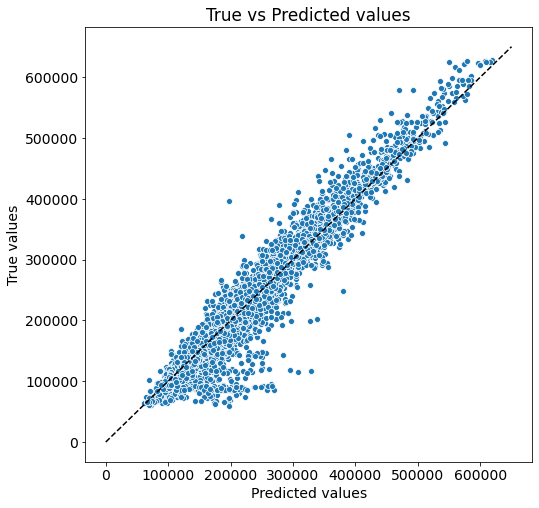

In [26]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.752
RMSE:	46168.94
MSE:	2131571051.282


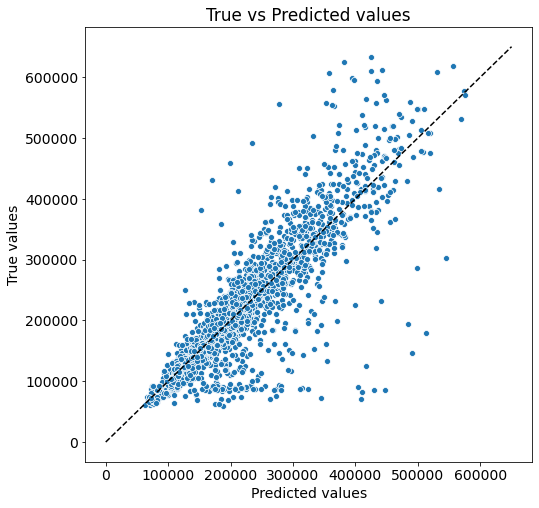

In [27]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

In [29]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

In [30]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,152950.625525
1,15856,218669.766422
2,5480,261078.579955
3,15664,326133.504544
4,14275,148709.661952
